In [1]:
import matplotlib.pyplot as plt
import time

from typing import Optional, Callable, Dict, Sequence
from dataclasses import dataclass, field
from tqdm import trange

import torch
import torch.nn.functional as F
import torch.backends.xnnpack

from torch import nn
from torch.amp import autocast
from torch.profiler import profile, schedule, ProfilerActivity

# KV cache

The KV-cache method in language models, specifically in the context of attention mechanisms like those used in Transformer models, refers to a technique where Key (K) and Value (V) vectors from previous attention operations are cached (stored) for reuse in subsequent operations. This method is primarily used to enhance efficiency and speed in autoregressive models, where the prediction of the next token in a sequence depends on the previously generated tokens.

By caching the Key and Value pairs from earlier tokens, the model avoids redundant computations for these tokens when processing new tokens in the sequence. This is particularly beneficial in tasks like text generation, where each new token prediction requires considering the entire preceding context. The KV-cache method thus enables faster and more computationally efficient inference, making real-time applications and longer sequence generation more feasible.

For more details follow the link https://mett29.github.io/posts/kv-cache/

<img width="716" alt="image" src="https://github.com/markovka17/dla/assets/20357655/f51e8cc7-ff13-4df1-88ae-23414e09412f">

In [18]:
import math


class SelfAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super().__init__()
        max_batch_size = 32
        max_seq_len = 512

        # Indicates the number of heads for the Keys and Values
        self.n_kv_heads = heads
        # Indicates the number of heads for the Queries
        self.n_heads_q = heads
        # Indicates how many times the Keys and Values should be repeated
        self.n_rep = self.n_heads_q // self.n_kv_heads
        # Indicates the dimension of each head, that is, the part of the embedding that each head will be responsible for
        self.head_dim = embed_size // heads

        self.wq = nn.Linear(embed_size, self.n_heads_q * self.head_dim, bias=False)
        self.wk = nn.Linear(embed_size, self.n_kv_heads * self.head_dim, bias=False)
        self.wv = nn.Linear(embed_size, self.n_kv_heads * self.head_dim, bias=False)
        self.wo = nn.Linear(heads * self.head_dim, embed_size, bias=False)

        cache_k = torch.zeros((max_batch_size, max_seq_len, self.n_kv_heads, self.head_dim))
        cache_v = torch.zeros((max_batch_size, max_seq_len, self.n_kv_heads, self.head_dim))
        self.register_buffer("cache_k", cache_k)
        self.register_buffer("cache_v", cache_v)

    def forward(self, x: torch.Tensor, start_pos: int = None, use_cache: bool = False):
        batch_size, seq_len, _ = x.shape  # (B, 1, Dim) 
        # seq_len equals 1 during the decoding phase and equals the length of the prompt during prefilling
        xq = self.wq(x)  # (B, 1, Dim) -> (B, 1, H_Q * Head_Dim)
        xk = self.wk(x)  # (B, 1, Dim) -> (B, 1, H_KV * Head_Dim)
        xv = self.wv(x)  # (B, 1, Dim) -> (B, 1, H_KV * Head_Dim)

        # (B, 1, H_Q * Head_Dim) -> (B, 1, H_Q, Head_Dim)
        xq = xq.view(batch_size, seq_len, self.n_heads_q, self.head_dim)
        xk = xk.view(batch_size, seq_len, self.n_kv_heads, self.head_dim)
        xv = xv.view(batch_size, seq_len, self.n_kv_heads, self.head_dim)

        # (B, Seq_Len_KV, H_KV, Head_Dim)
        if use_cache:
            # Replace the entry in the cache
            self.cache_k[:batch_size, start_pos : start_pos + seq_len] = xk
            self.cache_v[:batch_size, start_pos : start_pos + seq_len] = xv

            # All context
            keys = self.cache_k[:batch_size, : start_pos + seq_len]
            values = self.cache_v[:batch_size, : start_pos + seq_len]
        else:
            keys = xk
            values = xv

        # (B, 1, H_Q, Head_Dim) -> (B, H_Q, 1, Head_Dim)
        xq = xq.transpose(1, 2)
        keys = keys.transpose(1, 2)
        values = values.transpose(1, 2)

        scores = torch.matmul(xq, keys.transpose(2, 3)) / math.sqrt(self.head_dim)
        scores = F.softmax(scores.float(), dim=-1).type_as(xq)
        output = torch.matmul(scores, values)
        output = (output.transpose(1, 2).contiguous().view(batch_size, seq_len, -1))
        return self.wo(output)

100%|██████████| 512/512 [00:00<00:00, 1453.83it/s]


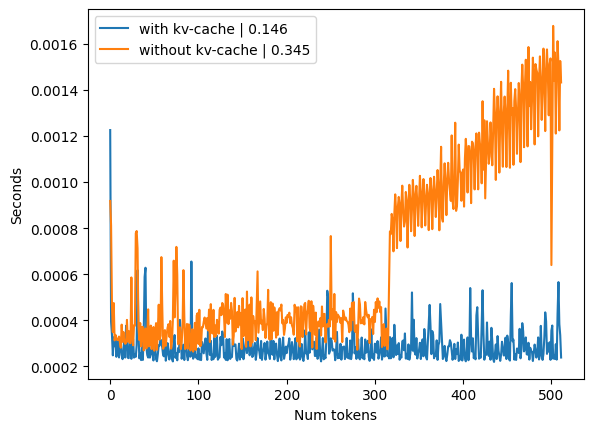

In [19]:
device = "cuda:2"

sa = SelfAttention(1024, 8).to(device)

num_tokens = 512
use_kv_cache = True
time_per_step = []


def generate(num_tokens, use_kv_cache):
    time_per_step = []
    current_result = torch.randn(32, num_tokens, 1024).to(device)

    for token_index in trange(num_tokens):
        torch.cuda.synchronize()
        start_t = time.perf_counter()

        with torch.inference_mode():
            if use_kv_cache:
                res = sa(current_result[:, token_index : token_index + 1 ], start_pos=token_index, use_cache=True)
                current_result[:, token_index + 1:token_index + 2] = res
            else:
                res = sa(current_result[:, :token_index + 1], use_cache=False)
                current_result[:, token_index + 1:token_index + 2] = res[:, -1].unsqueeze(dim=1)
    
        torch.cuda.synchronize()
        ellapsed_t = time.perf_counter() - start_t
        time_per_step.append(ellapsed_t)
    return time_per_step

warmup = generate(num_tokens, use_kv_cache=True)
total_time_with_kv_cache = generate(num_tokens, use_kv_cache=True)
warmup = generate(num_tokens, use_kv_cache=False)
total_time_without_kv_cache = generate(num_tokens, use_kv_cache=False)

plt.plot(total_time_with_kv_cache, label=f"with kv-cache | {sum(total_time_with_kv_cache):.3f}")
plt.plot(total_time_without_kv_cache, label=f"without kv-cache | {sum(total_time_without_kv_cache):.3f}")
plt.xlabel("Num tokens")
plt.ylabel("Seconds")
plt.legend();


# Triton

The aim of the Triton framework, developed by OpenAI, is to simplify and optimize the development of highly efficient GPU-based computations for deep learning models. It provides a Python-like programming environment that allows researchers and developers to write highly parallel and performant custom operations more easily than traditional GPU programming approaches, such as CUDA. Triton aims to make it more accessible for developers to leverage GPU acceleration, ultimately facilitating the development of faster and more efficient deep learning models.

The examples are taken from https://triton-lang.org/main/index.html, so feel free to read the documentation yourself.

Why do we need Triton?
1) Easier to write an efficient kernel
2) Automated work with memory and shared memory

Note: Both, CUDA and Triton compile into PTX.

Why do we still need CUDA then?

## Vector Addition

In [20]:
# import os
# os.environ["TRITON_INTERPRET"] = "1"

import triton
import triton.language as tl

In [21]:
@triton.jit
def add_kernel(
    x_ptr,  # *Pointer* to first input vector.
    y_ptr,  # *Pointer* to second input vector.
    output_ptr,  # *Pointer* to output vector.

    n_elements,  # Size of the vector.
    BLOCK_SIZE: tl.constexpr,  # Number of elements each program should process.
    # NOTE: `constexpr` so it can be used as a shape value.
):
    # There are multiple 'programs' processing different data. We identify which program
    # we are here:

    pid = tl.program_id(axis=0)  # We use a 1D launch grid so axis is 0.

    # This program will process inputs that are offset from the initial data.
    # For instance, if you had a vector of length 256 and block_size of 64, the programs
    # would each access the elements [0:64, 64:128, 128:192, 192:256].
    # Note that offsets is a list of pointers:
    block_start = pid * BLOCK_SIZE
    offsets = block_start + tl.arange(0, BLOCK_SIZE)

    # NOTE
    # tl.device_print('arange', tl.arange(0, BLOCK_SIZE))

    # Create a mask to guard memory operations against out-of-bounds accesses.
    mask = offsets < n_elements
    # Load x and y from DRAM, masking out any extra elements in case the input is not a
    # multiple of the block size.

    x = tl.load(x_ptr + offsets, mask=mask)
    y = tl.load(y_ptr + offsets, mask=mask)
    output = x + y

    # Write x + y back to DRAM.
    tl.store(output_ptr + offsets, output, mask=mask)

In [22]:
def add(x: torch.Tensor, y: torch.Tensor):
    # We need to preallocate the output.
    output = torch.empty_like(x)
    # assert x.is_cuda and y.is_cuda and output.is_cuda
    n_elements = output.numel()

    # The SPMD (single program, multiple data) launch grid denotes the number of kernel instances that run in parallel.
    # It is analogous to CUDA launch grids. It can be either Tuple[int], or Callable(metaparameters) -> Tuple[int].
    # In this case, we use a 1D grid where the size is the number of blocks:
    grid = lambda meta: (triton.cdiv(n_elements, meta['BLOCK_SIZE']), )

    # NOTE:
    #  - Each torch.tensor object is implicitly converted into a pointer to its first element.
    #  - `triton.jit`'ed functions can be indexed with a launch grid to obtain a callable GPU kernel.
    #  - Don't forget to pass meta-parameters as keywords arguments.

    add_kernel[grid](x, y, output, n_elements, BLOCK_SIZE=1024)
    
    # We return a handle to z but, since `torch.cuda.synchronize()` hasn't been called, the kernel is still
    # running asynchronously at this point.
    return output

In [23]:
torch.manual_seed(0)
size = 98432
x = torch.rand(size, device="cuda")
y = torch.rand(size, device="cuda")
output_torch = x + y
output_triton = add(x, y)
print(output_torch)
print(output_triton)
print(f'The maximum difference between torch and triton is '
      f'{torch.max(torch.abs(output_torch - output_triton))}')

tensor([1.3713, 1.3076, 0.4940,  ..., 0.6724, 1.2141, 0.9733], device='cuda:0')
tensor([1.3713, 1.3076, 0.4940,  ..., 0.6724, 1.2141, 0.9733], device='cuda:0')
The maximum difference between torch and triton is 0.0


## What is a stride in memory formats?

In memory formats, a stride is a term that describes the step size or the distance (measured in elements or bytes) between consecutive elements of a data structure (such as an array or a tensor) along a particular dimension when laid out in memory. Strides are crucial for efficiently accessing multi-dimensional data structures, especially when dealing with operations that require reshaping, slicing, or broadcasting of data without physically rearranging it in memory.

For instance, consider a 2D array (matrix) stored in row-major order (common in C and Python numpy arrays), where all elements of a row are stored in contiguous memory locations. The stride along the row dimension (often called the "row stride") would be 1, indicating that elements along a row are adjacent in memory. The stride along the column dimension (the "column stride"), however, would be equal to the number of columns in the array, as one has to skip all elements of a row to move to the next element in a column.

By manipulating strides, software libraries can implement operations like transposition, slicing, and various tensor manipulations efficiently, allowing for complex data manipulations without the need for expensive memory copies. Strides are a fundamental concept in libraries that handle multi-dimensional data structures, ensuring data is accessed and manipulated efficiently in memory.


![rowmajorcolmajor](./images/rowcolumnarrays.webp)

In [ ]:
import torch.backends.xnnpack

print("XNNPACK is enabled: ", torch.backends.xnnpack.enabled, "\n")

N, C, H, W = 2, 3, 200, 200
x = torch.rand(N, C, H, W)
print("Contiguous shape: ", x.shape)
print("Contiguous stride: ", x.stride())
print()

xcl = x.to(memory_format=torch.channels_last)
print("Channels-Last shape: ", xcl.shape)
print("Channels-Last stride: ", xcl.stride())

## MatMul

![image](https://triton-lang.org/main/_images/grouped_vs_row_major_ordering.png)

In [26]:

# `triton.jit`'ed functions can be auto-tuned by using the `triton.autotune` decorator, which consumes:
#   - A list of `triton.Config` objects that define different configurations of
#       meta-parameters (e.g., `BLOCK_SIZE_M`) and compilation options (e.g., `num_warps`) to try
#   - An auto-tuning *key* whose change in values will trigger evaluation of all the
#       provided configs
@triton.autotune(
    configs=[
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=3,
                      num_warps=8),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=5,
                      num_warps=2),
        triton.Config({'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=5,
                      num_warps=2),
    ],
    key=['M', 'N', 'K'],
)
@triton.jit
def matmul_kernel(
        # Pointers to matrices
        a_ptr, b_ptr, c_ptr,
        # Matrix dimensions
        M, N, K,
        # The stride variables represent how much to increase the ptr by when moving by 1
        # element in a particular dimension. E.g. `stride_am` is how much to increase `a_ptr`
        # by to get the element one row down (A has M rows).
        stride_am, stride_ak,  #
        stride_bk, stride_bn,  #
        stride_cm, stride_cn,
        # Meta-parameters
        BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,  #
        GROUP_SIZE_M: tl.constexpr,  #
        ACTIVATION: tl.constexpr  #
):
    """Kernel for computing the matmul C = A x B.
    A has shape (M, K), B has shape (K, N) and C has shape (M, N)
    """
    # -----------------------------------------------------------
    # Map program ids `pid` to the block of C it should compute.
    # This is done in a grouped ordering to promote L2 data reuse.
    # See above `L2 Cache Optimizations` section for details.
    pid = tl.program_id(axis=0)
    
    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
    num_pid_in_group = GROUP_SIZE_M * num_pid_n
    group_id = pid // num_pid_in_group
    first_pid_m = group_id * GROUP_SIZE_M
    group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)

    pid_m = first_pid_m + (pid % group_size_m)
    pid_n = (pid % num_pid_in_group) // group_size_m

    # ----------------------------------------------------------
    # Create pointers for the first blocks of A and B.
    # We will advance this pointer as we move in the K direction
    # and accumulate
    # `a_ptrs` is a block of [BLOCK_SIZE_M, BLOCK_SIZE_K] pointers
    # `b_ptrs` is a block of [BLOCK_SIZE_K, BLOCK_SIZE_N] pointers
    # See above `Pointer Arithmetic` section for details
    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M
    offs_bn = (pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)) % N
    offs_k = tl.arange(0, BLOCK_SIZE_K)
    a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak)
    b_ptrs = b_ptr + (offs_k[:, None] * stride_bk + offs_bn[None, :] * stride_bn)

    # -----------------------------------------------------------
    # Iterate to compute a block of the C matrix.
    # We accumulate into a `[BLOCK_SIZE_M, BLOCK_SIZE_N]` block
    # of fp32 values for higher accuracy.
    # `accumulator` will be converted back to fp16 after the loop.
    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)
    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        # Load the next block of A and B, generate a mask by checking the K dimension.
        # If it is out of bounds, set it to 0.
        a = tl.load(a_ptrs, mask=offs_k[None, :] < K - k * BLOCK_SIZE_K, other=0.0)
        b = tl.load(b_ptrs, mask=offs_k[:, None] < K - k * BLOCK_SIZE_K, other=0.0)
        # We accumulate along the K dimension.
        accumulator += tl.dot(a, b)
        # Advance the ptrs to the next K block.
        a_ptrs += BLOCK_SIZE_K * stride_ak
        b_ptrs += BLOCK_SIZE_K * stride_bk
    # You can fuse arbitrary activation functions here
    # while the accumulator is still in FP32!
    
    if ACTIVATION == "leaky_relu":
        accumulator = leaky_relu(accumulator)
    c = accumulator.to(tl.float16)

    # -----------------------------------------------------------
    # Write back the block of the output matrix C with masks.
    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    tl.store(c_ptrs, c, mask=c_mask)


# We can fuse `leaky_relu` by providing it as an `ACTIVATION` meta-parameter in `_matmul`.
@triton.jit
def leaky_relu(x):
    x = x + 1
    return tl.where(x >= 0, x, 0.01 * x)

In [27]:
def matmul(a, b, activation="", verbose=False):
    # Check constraints.
    assert a.shape[1] == b.shape[0], "Incompatible dimensions"
    assert a.is_contiguous(), "Matrix A must be contiguous"
    assert b.is_contiguous(), "Matrix B must be contiguous"
    M, K = a.shape
    K, N = b.shape

    # Allocates output.
    c = torch.empty((M, N), device=a.device, dtype=a.dtype)

    if verbose:
        print(f"{M=} {K=} {N=}")
        print(f"{a.stride(0)=}, {a.stride(1)=}")
        print(f"{b.stride(0)=}, {b.stride(1)=}")
        print(f"{c.stride(0)=}, {c.stride(1)=}")

    # 1D launch kernel where each block gets its own program.
    grid = lambda META: (triton.cdiv(M, META['BLOCK_SIZE_M']) * triton.cdiv(N, META['BLOCK_SIZE_N']), )
    matmul_kernel[grid](
        a, b, c,  #
        M, N, K,  #
        a.stride(0), a.stride(1),  #
        b.stride(0), b.stride(1),  #
        c.stride(0), c.stride(1),  #
        ACTIVATION=activation  #
    )
    return c

In [28]:
a = torch.randn((512, 512), device='cuda', dtype=torch.float16)
b = torch.randn((512, 512), device='cuda', dtype=torch.float16)
triton_output = matmul(a, b, activation="")
output = a @ b

In [ ]:
triton_output - output

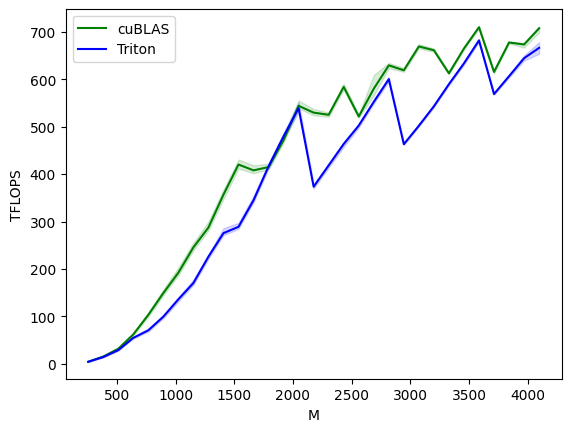

In [12]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['M', 'N', 'K'],  # Argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(2, 33)],  # Different possible values for `x_name`
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot
        # Possible values for `line_arg`
        line_vals=['cublas', 'triton'],
        # Label name for the lines
        line_names=["cuBLAS", "Triton"],
        # Line styles
        styles=[('green', '-'), ('blue', '-')],
        ylabel="TFLOPS",  # Label name for the y-axis
        plot_name="matmul-performance",  # Name for the plot, used also as a file name for saving the plot.
        args={},
    ))
def benchmark(M, N, K, provider):
    a = torch.randn((M, K), device='cuda', dtype=torch.float16)
    b = torch.randn((K, N), device='cuda', dtype=torch.float16)
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'cublas':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.matmul(a, b), quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: matmul(a, b), quantiles=quantiles)
    perf = lambda ms: 2 * M * N * K * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)


benchmark.run(show_plots=True, print_data=False)

# Fusing

<p float="left">
<img src="./images/fused_kernels1.png" width="400"/>
<img src="./images/fused_kernels2.png" width="400"/>
</p>

## Projections Fusing

This technique aims to reduce the number of operations. Instead of 3 matrix multiplications (projections on q, k and v) 
we will have one big one, due to which we will reduce the number of calls and memory moves to GPU registers.

The main work will take place in the `fuse_qkv` function, which should be called once before using the layer.

In [30]:
class DummySelfAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super().__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert self.head_dim * heads == embed_size, "Embed size needs to be divisible by heads"

        # Linear layers to generate Query, Key, and Value matrices
        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)

        self.fc_out = nn.Linear(heads * self.head_dim, embed_size)

        self.fused_qkv_projection = None

    def fuse_qkv(self):
        @torch.no_grad()
        def fuse_projections(*projections: Sequence[nn.Linear]) -> nn.Linear:
            concatenated_weights = torch.cat([p.weight.data for p in projections])
            device = concatenated_weights.device
            dtype = concatenated_weights.dtype
            in_features = concatenated_weights.shape[1]
            out_features = concatenated_weights.shape[0]
            projection = nn.Linear(in_features, out_features, bias=False, device=device, dtype=dtype)
            projection.weight.copy_(concatenated_weights)
            return projection
        
        self.fused_qkv_projection = fuse_projections(self.queries, self.keys, self.values)
        del self.queries, self.keys, self.values

    def forward(self, input: torch.Tensor, kv_cache=None) -> torch.Tensor:
        batch_size = input.shape[0]
        input_len = input.shape[1]

        # Split the embedding into self.heads pieces
        input = input.reshape(batch_size, input_len, self.heads, self.head_dim)

        if self.fused_qkv_projection is None:
            q = self.queries(input)
            k = self.keys(input)
            v = self.values(input)
        else:
            q, k, v = self.fused_qkv_projection(input).chunk(chunks=3, dim=-1)

        # Scaled Dot-Product Attention
        energy = torch.einsum("nqhd,nkhd->nhqk", [q, k])
        attention = torch.softmax(energy / (self.embed_size ** (1 / 2)), dim=3)
        out = torch.einsum("nhql,nlhd->nqhd", [attention, v]).reshape(batch_size, input_len, self.heads*self.head_dim)
        return self.fc_out(out)


In [31]:
@dataclass
class ProfilerConfig:
    scheduler: Optional[Callable[[int], int]] = field(default=None, metadata={"omegaconf_ignore": True})
    num_steps: int = field(init=False)
    amp: bool = False

    def __post_init__(self):
        if self.scheduler is None:
            self.scheduler = {"skip_first": 2, "wait": 2, "warmup": 3, "active": 3, "repeat": 0}

        self.num_steps = sum([v for k, v in self.scheduler.items() if k != "repeat"])
        self.scheduler = schedule(**self.scheduler)

@torch.inference_mode()
def profile_model(model: nn.Module, input: Dict[str, torch.Tensor], config: ProfilerConfig):
    training_state = model.training
    model.eval()

    with autocast(dtype=torch.float16, device_type="cuda", enabled=config.amp), profile(
        activities=[ProfilerActivity.CUDA ],
        schedule=config.scheduler
    ) as p:
        for _ in range(config.num_steps):
            _ = model(**input)
            p.step()

    model.train(training_state)
    return p

In [15]:
sa = DummySelfAttention(1024, 8).cuda()
sa_input = torch.randn(32, 128, 1024).cuda()

p = profile_model(sa, {'input': sa_input}, ProfilerConfig(amp=False))
print(p.key_averages())

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                 cudaDeviceGetAttribute         1.54%       5.454us         1.54%       5.454us       0.364us       0.000us         0.00%       0.000us       0.000us            15  
                                         cuLaunchKernel        41.04%     145.657us        41.04%     145.657us       9.710us       0.000us         0.00%       0.000us       0.000us            15  
void cutl

In [16]:
sa_fused = DummySelfAttention(1024, 8).cuda()
sa_fused.load_state_dict(sa.state_dict())
sa_fused.fuse_qkv()

p = profile_model(sa_fused, {'input': sa_input}, ProfilerConfig(amp=False))
print(p.key_averages())

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        cudaMemsetAsync         5.54%      15.886us         5.54%      15.886us       5.295us       0.000us         0.00%       0.000us       0.000us             3  
                                  cudaFuncGetAttributes         8.26%      23.698us         8.26%      23.698us       1.975us       0.000us         0.00%       0.000us       0.000us            12  
         

In [17]:
torch.testing.assert_close(sa(sa_input), sa_fused(sa_input))

As we can see the result of work with and without fusing is identical, but at the same time we see a 7-10% increase in timing

### Large scale

For larger nets, the absolute value of acceleration will be larger

In [18]:
sa_large = nn.Sequential(*[DummySelfAttention(1024, 8)] * 10).cuda()

p = profile_model(sa_large, {'input': sa_input}, ProfilerConfig(amp=False))
print(p.key_averages())

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                 cudaDeviceGetAttribute         1.43%      37.130us         1.43%      37.130us       0.248us       0.000us         0.00%       0.000us       0.000us           150  
                                         cuLaunchKernel        37.54%     976.090us        37.54%     976.090us       6.507us       0.000us         0.00%       0.000us       0.000us           150  
void cutl

In [19]:
sa_fused_large = nn.Sequential(*[DummySelfAttention(1024, 8)] * 10).cuda()
for m in sa_fused_large.modules():
    if isinstance(m, DummySelfAttention):
        m.fuse_qkv()

p = profile_model(sa_fused_large, {'input': sa_input}, ProfilerConfig(amp=False))
print(p.key_averages())

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        cudaMemsetAsync         3.56%     128.696us         3.56%     128.696us       4.290us       0.000us         0.00%       0.000us       0.000us            30  
                                  cudaFuncGetAttributes         6.75%     243.670us         6.75%     243.670us       2.031us       0.000us         0.00%       0.000us       0.000us           120  
         

## Element-wise Fusing

The following optimization is similar to the previous one. In modern DL there are many activations, which is a composition of simple operations, e.g. elementwise multiplication/addition, sigmoid/tangent.

In case we naively implement such activations, each elementwise operation is performed by a separate kernel. That is, we load memory into it, perform the operation and return the memory back.
Such memory management is very slow, so it is much better to perform all operations in a single kernel

This fusion of operations can be achieved with the help of decorator `@torch.compile`

In [20]:
@torch.compile
def fused_geglu(x, gate):
    """
    Gaussian error Gated Linear Units, GeGLU(x) = GeLU(x) * gate
    from the paper https://arxiv.org/abs/2002.05202
    """
    tanh = torch.tanh(0.79788456 * x * (1 + 0.044715 * x * x))
    return gate * (x * 0.5 * (1.0 + tanh))


class _FusedGeGLU(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x: torch.Tensor, gate: torch.Tensor):
        ctx.save_for_backward(x, gate)
        return fused_geglu(x, gate)
    

def geglu(x, gate):
    """
    Gaussian error Gated Linear Units, GeGLU(x) = GeLU(x) * gate
    from the paper https://arxiv.org/abs/2002.05202
    """
    tanh = torch.tanh(0.79788456 * x * (1 + 0.044715 * x * x))
    return gate * (x * 0.5 * (1.0 + tanh))

class _GeGLU(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x: torch.Tensor, gate: torch.Tensor):
        ctx.save_for_backward(x, gate)
        return geglu(x, gate)


class GeGLU(nn.Module):

    def __init__(self, d_in: int, d_out: int, impl: str):
        super().__init__()
        # Combined linear projections $xW + b$ and $xV + c$
        self.proj = nn.Linear(d_in, d_out * 2)
        self._impl= impl

    def forward(self, input: torch.Tensor):
        x, gate = self.proj(input).chunk(2, dim=-1)
        if self._impl == "naive":
            return _GeGLU.apply(x, gate)
        return _FusedGeGLU.apply(x, gate)


In [21]:
act = GeGLU(2048, 2048, impl="naive").cuda()
act_input = torch.randn(32, 128, 2048).cuda()

p = profile_model(act, {'input': act_input}, ProfilerConfig(amp=False))
print(p.key_averages())

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        cudaMemsetAsync         1.03%      15.567us         1.03%      15.567us       5.189us       0.000us         0.00%       0.000us       0.000us             3  
                                  cudaFuncGetAttributes         0.86%      13.038us         0.86%      13.038us       2.173us       0.000us         0.00%       0.000us       0.000us             6  
         

In [22]:
act_fused = GeGLU(2048, 2048, impl="fast").cuda()
act_fused.load_state_dict(act.state_dict())

p = profile_model(act_fused, {'input': act_input}, ProfilerConfig(amp=False))
print(p.key_averages())

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        cudaMemsetAsync        10.15%      18.262us        10.15%      18.262us       6.087us       0.000us         0.00%       0.000us       0.000us             3  
                                  cudaFuncGetAttributes         7.04%      12.667us         7.04%      12.667us       2.111us       0.000us         0.00%       0.000us       0.000us             6  
         

In [23]:
torch.testing.assert_close(act(act_input), act_fused(act_input))

As you can see this method gives a gain of almost two times in speed 

## Liger Kernels

Here is also a great and simple example on fusing + triton from Liger Kernels repo.

In [24]:
import torch
import triton
import triton.language as tl

from liger_kernel.ops.utils import calculate_settings
from liger_kernel.ops.utils import ensure_contiguous


@triton.jit
def _silu(x):
    return x * tl.sigmoid(x)


@triton.jit
def _swiglu_forward_kernel(a_ptr, b_ptr, c_ptr, stride, n_cols: tl.constexpr, BLOCK_SIZE: tl.constexpr):
    program_id = tl.program_id(0).to(tl.int64)

    # locate start index
    a_ptr += program_id * stride
    b_ptr += program_id * stride
    c_ptr += program_id * stride

    col_offsets = tl.arange(0, BLOCK_SIZE)
    mask = col_offsets < n_cols

    # sigmoid requires type float32
    a_row = tl.load(a_ptr + col_offsets, mask=mask, other=0).to(tl.float32)
    b_row = tl.load(b_ptr + col_offsets, mask=mask, other=0)
    c_row = _silu(a_row) * b_row
    tl.store(c_ptr + col_offsets, c_row, mask=mask)


@triton.jit
def _swiglu_backward_kernel(dc_ptr, a_ptr, b_ptr, stride, n_cols: tl.constexpr, BLOCK_SIZE: tl.constexpr):
    program_id = tl.program_id(0).to(tl.int64)

    # locate start index
    dc_ptr += program_id * stride
    a_ptr += program_id * stride
    b_ptr += program_id * stride

    col_offsets = tl.arange(0, BLOCK_SIZE)
    mask = col_offsets < n_cols

    dc_row = tl.load(dc_ptr + col_offsets, mask=mask, other=0)
    # sigmoid requires type float32
    a_row = tl.load(a_ptr + col_offsets, mask=mask, other=0).to(tl.float32)
    b_row = tl.load(b_ptr + col_offsets, mask=mask, other=0)

    # recomputation to save memory
    sig_a = tl.sigmoid(a_row)
    silu_a = a_row * sig_a
    db_row = dc_row * silu_a
    da_row = dc_row * (silu_a * (1 - sig_a) + sig_a) * b_row

    tl.store(a_ptr + col_offsets, da_row, mask=mask)
    tl.store(b_ptr + col_offsets, db_row, mask=mask)


def swiglu_forward(a, b):
    ori_shape = a.shape

    n_cols = ori_shape[-1]
    a = a.view(-1, n_cols)
    b = b.view(-1, n_cols)
    c = torch.empty_like(a)
    n_rows = a.shape[0]

    BLOCK_SIZE, num_warps = calculate_settings(n_cols)

    _swiglu_forward_kernel[(n_rows,)](
        a,
        b,
        c,
        c.stride(-2),
        n_cols=n_cols,
        BLOCK_SIZE=BLOCK_SIZE,
        num_warps=num_warps,
    )
    return a, b, c.view(*ori_shape)


def swiglu_backward(a, b, dc):
    ori_shape = dc.shape
    n_cols = ori_shape[-1]
    dc = dc.view(-1, n_cols)
    n_rows = dc.shape[0]

    BLOCK_SIZE, num_warps = calculate_settings(n_cols)

    _swiglu_backward_kernel[(n_rows,)](
        dc,
        a,
        b,
        dc.stride(-2),
        n_cols=n_cols,
        BLOCK_SIZE=BLOCK_SIZE,
        num_warps=num_warps,
    )
    return a.view(*ori_shape), b.view(*ori_shape)


class LigerSiLUMulFunction(torch.autograd.Function):
    @staticmethod
    @ensure_contiguous
    def forward(ctx, a, b):
        a, b, c = swiglu_forward(a, b)
        ctx.save_for_backward(a, b)
        return c

    @staticmethod
    @ensure_contiguous
    def backward(ctx, dc):
        a, b = ctx.saved_tensors
        a, b = swiglu_backward(a, b, dc)
        return a, b

In [25]:
class SwigluLiger(nn.Module):
    def __init__(self, d_in: int, d_out: int):
        super().__init__()
        self.proj = nn.Linear(d_in, d_out * 2)

    def forward(self, input: torch.Tensor):
        x, gate = self.proj(input).chunk(2, dim=-1)
        return LigerSiLUMulFunction.apply(x, gate)

In [26]:
act_fused = SwigluLiger(2048, 2048).cuda()
act_fused.load_state_dict(act.state_dict())

p = profile_model(act_fused, {'input': act_input}, ProfilerConfig(amp=False))
print(p.key_averages())

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                 _swiglu_forward_kernel         0.00%       0.000us         0.00%       0.000us       0.000us     135.552us        14.52%     135.552us      33.888us             4  
                                        cudaMemsetAsync         3.79%      15.730us         3.79%      15.730us       5.243us       0.000us         0.00%       0.000us       0.000us             3  
         

Here you can check a lot of great examples of how to fuse operations and write triton kernels. [Liger Kernels repo](https://github.com/linkedin/Liger-Kernel/tree/main/src/liger_kernel/ops), [Liger Kernels paper](https://arxiv.org/pdf/2410.10989).

# Flash Attention

Flash Attention is a highly efficient attention mechanism designed to significantly reduce the computational cost and memory usage associated with processing large-scale inputs in Transformer models. It leverages a novel algorithm that allows for the computation of attention weights and the aggregation of context vectors in a single pass, improving both speed and efficiency. This innovation enables the handling of longer sequences in natural language processing tasks and other applications, making Transformers more scalable and practical for a broader range of datasets and computational constraints.

[FlashAttention](https://arxiv.org/pdf/2205.14135)

[FlassAttention2](https://arxiv.org/pdf/2307.08691)

[FlassAttention3](https://arxiv.org/pdf/2407.08608)

In [ ]:
tokens = 1024
seqlens_q = [400, 500, 124]
seqlens_q = [0, 400, 900, 1024]

In [9]:
def flash_attn_varlen_func(
    q,
    k,
    v,
    cu_seqlens_q,
    cu_seqlens_k,
    max_seqlen_q,
    max_seqlen_k,
    dropout_p=0.0,
    softmax_scale=None,
    causal=False,
    window_size=(-1, -1),  # -1 means infinite context window
    softcap=0.0, # 0.0 means deactivated
    alibi_slopes=None,
    deterministic=False,
    return_attn_probs=False,
    block_table=None,
):
    """dropout_p should be set to 0.0 during evaluation
    Supports multi-query and grouped-query attention (MQA/GQA) by passing in K, V with fewer heads
    than Q. Note that the number of heads in Q must be divisible by the number of heads in KV.
    For example, if Q has 6 heads and K, V have 2 heads, head 0, 1, 2 of Q will attention to head
    0 of K, V, and head 3, 4, 5 of Q will attention to head 1 of K, V.

    If causal=True, the causal mask is aligned to the bottom right corner of the attention matrix.
    For example, if seqlen_q = 2 and seqlen_k = 5, the causal mask (1 = keep, 0 = masked out) is:
        1 1 1 1 0
        1 1 1 1 1
    If seqlen_q = 5 and seqlen_k = 2, the causal mask is:
        0 0
        0 0
        0 0
        1 0
        1 1
    If the row of the mask is all zero, the output will be zero.
    """
    pass

In [10]:
class DummyAttention(nn.Module):
    def forward(self, q, k, v):
        return F.scaled_dot_product_attention(q, k, v)

In [11]:
dummy_attention = DummyAttention()
dtype = torch.bfloat16

In [12]:
from torch.nn.attention import SDPBackend, sdpa_kernel

In [13]:
q = torch.randn(64, 8192, 8, 128, dtype=dtype, device="cuda")
k = torch.randn(64, 8192, 8, 128, dtype=dtype, device="cuda")
v = torch.randn(64, 8192, 8, 128, dtype=dtype, device="cuda")

with sdpa_kernel(SDPBackend.FLASH_ATTENTION):
    p = profile_model(dummy_attention, {'q': q, 'k': k, 'v': v}, ProfilerConfig(amp=False))
    print(p.key_averages())

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
void pytorch_flash::flash_fwd_kernel<pytorch_flash::...         0.00%       0.000us         0.00%       0.000us       0.000us      58.893ms       100.00%      58.893ms      11.779ms             5  
                                  cudaStreamIsCapturing         0.04%      15.744us         0.04%      15.744us       5.248us       0.000us         0.00%       0.000us       0.000us             3  
         

In [14]:
with sdpa_kernel(SDPBackend.MATH):
    p = profile_model(dummy_attention, {'q': q, 'k': k, 'v': v}, ProfilerConfig(amp=False))
    print(p.key_averages())

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                       cudaLaunchKernel         0.22%     358.657us         0.22%     358.657us       5.978us       0.000us         0.00%       0.000us       0.000us            60  
                                 cudaDeviceGetAttribute         0.00%       1.502us         0.00%       1.502us       0.501us       0.000us         0.00%       0.000us       0.000us             3  
         

# Flex Attention

More flexible approach to efficient attention implementation. [Flex Attention Tutorial](https://pytorch.org/blog/flexattention/).



## Score Mod

In [13]:
def noop(score, b, h, q_idx, kv_idx):
    return score

In [14]:
def relative_positional(score, b, h, q_idx, kv_idx):
    return score + (q_idx - kv_idx)

In [15]:
def causal_mask(score, b, h, q_idx, kv_idx):
    return torch.where(q_idx >= kv_idx, score, -float("inf"))

In [25]:
dtype = torch.float16
q = torch.randn(64, 1024, 8, 128, dtype=dtype, device="cuda")
k = torch.randn(64, 1024, 8, 128, dtype=dtype, device="cuda")
v = torch.randn(64, 1024, 8, 128, dtype=dtype, device="cuda")

In [38]:
from torch.nn.attention.flex_attention import flex_attention
from torch.nn.attention import SDPBackend, sdpa_kernel

with sdpa_kernel(SDPBackend.FLASH_ATTENTION):
    flash = F.scaled_dot_product_attention(q, k, v)

flex = flex_attention(q, k, v, score_mod=noop)

torch.max(torch.abs(flex - flash))

tensor(0.0039, device='cuda:0', dtype=torch.float16)

## Mask Mods

In [ ]:
# returns True if this position should participate in the computation
# mask_mod(b, h, q_idx, kv_idx) => bool

In [ ]:
from torch.nn.attention.flex_attention import create_block_mask

def causal(b, h, q_idx, kv_idx):
    return q_idx >= kv_idx

# Because the sparsity pattern is independent of batch and heads, we'll set them to None (which broadcasts them) 
block_mask = create_block_mask(causal, B=None, H=None, Q_LEN=1024, KV_LEN=1024)
flex_attention(q, k, v, block_mask=block_mask)

In [44]:
SLIDING_WINDOW = 1024

def sliding_window_causal(b, h, q_idx, kv_idx):
    causal_mask = q_idx >= kv_idx
    window_mask = q_idx - kv_idx <= SLIDING_WINDOW 
    return causal_mask & window_mask

![prefixLM](./images/prefixLM.png)

In [47]:
prefix_length = torch.tensor([20, 10]).cuda()
def prefix_lm_causal(b, h, q_idx, kv_idx):
    causal_mask = q_idx >= kv_idx
    return causal_mask | (kv_idx <= prefix_length[b])

# In this case, our mask is different per sequence so we set B equal to our batch size
block_mask = create_block_mask(prefix_lm_causal, B=2, H=None, Q_LEN=64, KV_LEN=64)